In [1]:
# All Imports
import sys 
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
#from sklearn.cluster import DBSCAN
import collections
#from sklearn.neighbors import NearestNeighbors
#from gensim.test.utils import common_texts
import pickle

from gensim.models.doc2vec import Doc2Vec #, TaggedDocument,KeyedVectors 
#from gensim.test.utils import get_tmpfile
import nltk
#from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

from sklearn.cluster import KMeans

In [4]:
test_documents_json = pickle.load( open( "counted_bows_test", "rb" ) ) #test_documents
print(len(test_documents_json))
train_documents_json = pickle.load( open( "counted_bows", "rb" ) ) #train_documents
print(len(train_documents_json))

10969
123984


In [3]:
train_documents = [TaggedDocument(i[0],i[1]) for i in train_documents_json]
test_documents = [TaggedDocument(i[0],i[1]) for i in test_documents_json]
print(train_documents[123])

TaggedDocument(['love', 'rememb', 'littl', 'when', 'into', 'gone', 'spring', 'smile', 'rememb', 'everi', 'see', 'eye', 'love', 'dawn', 'teardrop', 'shadow', 'dream', 'now', 'thing', 'kiss', 'far', 'love', 'was', 'color', 'star', 'lip', 'smile', 'look', 'shadow', 'thing', 'too', 'light', 'did', 'our', 'smile', 'high', 'when', 'love', 'littl'], ['1126283'])


In [3]:
nltk.download(["stopwords", "averaged_perceptron_tagger", "vader_lexicon"])

[nltk_data] Downloading package stopwords to /home/lilli/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lilli/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lilli/nltk_data...


True

In [7]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.append(nltk.corpus.stopwords.words("spanish"))
stopwords.append(nltk.corpus.stopwords.words("german"))
stopwords.append(nltk.corpus.stopwords.words("dutch"))
stopwords.append(nltk.corpus.stopwords.words("french"))
stopwords.append(nltk.corpus.stopwords.words("italian"))
stopwords.append('back', 'caus', 'yeah','thing',
 'tri','still', 'onli', 'around', 'fall', 'need', 'life', 'us', 'tell', 'tri', 'right', 'look',
 'away', 'stand', 'back', 'alway',
 'give', 'realli', 'alright', 'think','got', 'keep', 'need', 'let',
 'said','could', 'say', 'find', 'see', 'long', 'make')
def remove_stopwords(doc_corpus):
    new_corp = []
    for doc in doc_corpus:
        words = [w for w in doc[0] if w.lower() not in stopwords]
        if len(words) == 0:
            print("removed")
        else:
            new_corp.append([words,doc[1]])
    return new_corp

docs = remove_stopwords(train_documents_json)
print(len(docs))

123984


In [4]:
1126283


NameError: name 'test_dict' is not defined

In [ ]:
all_words = [item for sublist in docs for item in sublist[0]]

frequency_distribution = nltk.FreqDist(all_words)
print(frequency_distribution.most_common(5))

In [148]:
def add_freq_dist(doc_corpus):
    tfidf_dict = {} 
    for doc in doc_corpus:
        freq_dist_doc = nltk.FreqDist(doc[0])
        tfidf = [[w, freq_dist_doc[w]/frequency_distribution[w] ] for w in list(set(doc[0]))]
        tfidf_dict[doc[1][0]] = tfidf
    return tfidf_dict
with_tfidf = add_freq_dist(docs)  


In [35]:
corpus = [' '.join(x[0]) for x in docs]
vectorizer = TfidfVectorizer()
tfidf_x = vectorizer.fit_transform(corpus)

In [40]:
df_countvect = pd.DataFrame(data= tfidf_x.toarray(), index=[i[1][0] for i in docs], columns=vectorizer.get_feature_names() )

In [56]:
new_stopwords = [  'aan','ab']

for i in new_stopwords:
    del df_countvect[i]
print(df_countvect.head(), np.shape(df_countvect))
with open("tfidf_df.p","wb") as inf_json:
    pickle.dump(df_countvect,inf_json)

         abandon  abl  aboard  abov  absenc  absolut  absurd  abus  abyss  \
9791495      0.0  0.0     0.0   0.0     0.0      0.0     0.0   0.0    0.0   
3865960      0.0  0.0     0.0   0.0     0.0      0.0     0.0   0.0    0.0   
1173732      0.0  0.0     0.0   0.0     0.0      0.0     0.0   0.0    0.0   
4252601      0.0  0.0     0.0   0.0     0.0      0.0     0.0   0.0    0.0   
3010635      0.0  0.0     0.0   0.0     0.0      0.0     0.0   0.0    0.0   

         accept  ...  yuh   za   ze  zero   zo  zombi  zone  zoo  genre  \
9791495     0.0  ...  0.0  0.0  0.0   0.0  0.0    0.0   0.0  0.0      7   
3865960     0.0  ...  0.0  0.0  0.0   0.0  0.0    0.0   0.0  0.0      7   
1173732     0.0  ...  0.0  0.0  0.0   0.0  0.0    0.0   0.0  0.0      7   
4252601     0.0  ...  0.0  0.0  0.0   0.0  0.0    0.0   0.0  0.0      7   
3010635     0.0  ...  0.0  0.0  0.0   0.0  0.0    0.0   0.0  0.0      7   

         cluster  
9791495        0  
3865960        2  
1173732       14  
4252601   

In [94]:
train_documents = [TaggedDocument(i[0],[i[1][0]]) for i in docs]
modeld2v = Doc2Vec(documents=train_documents, vector_size=10, epochs=3, min_count=2, workers=6)
modeld2v.save("stopwords_removed.model")

In [95]:
modeld2v.train(train_documents, total_examples=modeld2v.corpus_count, epochs=100)
modeld2v.save("stopwords_removed.model")

In [185]:
model = Doc2Vec.load("stopwords_removed.model")

inferred_vectors = {}

for doc_id in df_countvect.index.tolist(): #len(test_documents)
    inferred_vector = model.dv[doc_id]
    inferred_vectors[doc_id] = inferred_vector
with open("inferred_vectors_dict.p","wb") as inf_json:
    pickle.dump(inferred_vectors,inf_json)
inf_json.close()

{'9791495': array([ 1.7962499, -7.9649706,  1.7355924,  3.8680243, -3.7675643,
        -2.7404475,  4.896098 ,  3.9590852,  2.1488748, -7.2219925],
       dtype=float32),
 '3865960': array([ 5.642887 , -1.2437263, -3.7731214,  3.962605 , -5.199503 ,
        -2.0390356,  0.4542667,  5.889685 , -2.0717258, -0.9092294],
       dtype=float32),
 '1173732': array([ 4.868579  , -1.358048  ,  4.4296193 ,  2.545414  , -0.63731796,
        -1.5812411 ,  2.3102536 , -0.8401492 ,  1.280471  ,  3.1137853 ],
       dtype=float32),
 '4252601': array([ 0.27257127, -1.2621993 ,  1.8776149 , -2.2049327 , -1.6589116 ,
        -0.03296081, -1.8661569 , -3.4653444 , -3.334479  , -0.6143811 ],
       dtype=float32),
 '3010635': array([-2.8933735 ,  4.039488  , -1.0467393 ,  5.8973374 , -3.2435431 ,
        -0.55918974, -2.050369  ,  3.7708733 , -3.4082456 , -2.9325638 ],
       dtype=float32),
 '4058740': array([-0.2675879 , -6.6692777 , -0.46382394, -5.926259  ,  1.7349393 ,
         2.626208  ,  6.365325 

In [8]:
corpus = [' '.join(x[0]) for x in docs]
vectorizer = TfidfVectorizer()
tfidf_x = vectorizer.fit_transform(corpus)
df_countvect = pd.DataFrame(data= tfidf_x.todense(), index=[i[1][0] for i in docs], columns=vectorizer.get_feature_names() )

with open("tfidf_df.p","wb") as inf_json:
    pickle.dump(df_countvect,inf_json)

In [3]:
def do_clustering(df, inferred):
    kmeans_model = KMeans(init='k-means++', n_clusters=20, n_init=10)
    kmeans_model.fit(np.array(list(inferred.values())))
    clustering = kmeans_model.labels_
    # join clusters and tf-idf
    #del df['cluster']
    clust_df = pd.DataFrame({'cluster': clustering}, index=[i for i in inferred.keys()])
    new_df = df.join(clust_df)
    with open("tfidf_df.p","wb") as inf_json:
        pickle.dump(new_df,inf_json)
    return new_df
        
#new_df = do_clustering()

In [9]:
def add_genre_todf():
    df = df_countvect #pickle.load( open( "tfidf_df.p", "rb" ) )
    test_dictionary = pickle.load( open( "test_dict.p", "rb" ) ) 
    genres = [i['index'] for i in test_dictionary.values()]
    clust_df = pd.DataFrame({'genre': genres}, index=[i for i in test_dictionary.keys()] )
    new_df = df.join(clust_df)
    new_df['genre'] = new_df['genre'].replace(np.nan, 7)
    new_df['genre'] = pd.to_numeric(new_df['genre'], downcast='signed')

    return new_df
new_g_df = add_genre_todf()
np.shape(new_g_df)
with open("tfidf_df.p","wb") as inf_json:
    pickle.dump(new_df,inf_json)

(123984, 3937)

In [12]:
with open("tfidf_df.p","wb") as inf_json:
    pickle.dump(new_g_df,inf_json)

In [18]:
def compute_test_with_topwords(X_embedded= None, df_countvect=None, new_clustering=False, new_tsne=False):
    # load data
    # vectors from doc2vec model doc_id: [vector]
    test_dictionary = pickle.load( open( "test_dict.p", "rb" ) )
    # tf-idf matrix: doc_id w1 w2 ... wn
    if df_countvect is None:
        df_countvect = pickle.load( open( "tfidf_df.p", "rb" ) )
    genre_labels = {i['index']:i['name'] for i in test_dictionary.values()}

    # np array of vectors
    X = np.array([i['vector'] for i in test_dictionary.values()])
    
    # apply t-SNE
    if new_tsne or X_embedded is None:
        X_embedded = TSNE(n_components=2, perplexity=100, learning_rate=200).fit_transform(X)
        X_embedded.shape
    
    tfidf_vecs = [] #df_countvect.loc(0)[list(test_dictionary.keys())]
    clustering = [] #list(tfidf_vecs['cluster'].to_numpy())
    if new_clustering:
        # cluster
        all_inferred = pickle.load( open( "inferred_vectors_dict.p", "rb" ) )
        df_countvect = do_clustering(df_countvect, all_inferred)
        tfidf_vecs = df_countvect.loc(0)[list(test_dictionary.keys())]
        clustering = list(tfidf_vecs['cluster'].to_numpy())
        print(set(clustering))
    else:
        tfidf_vecs = df_countvect.loc(0)[list(test_dictionary.keys())]
        clustering = list(tfidf_vecs['cluster'].to_numpy())   

    cluster_labels = []
    for i in range(20):
        cluster = df_countvect.loc(0)[df_countvect.loc(1)['cluster'] == i]
        cluster_mean = cluster.mean()
        top_words = cluster_mean.sort_values()
        cluster_labels.append(top_words[-30:-20])
        
    genre_topwords = []
    for i in range(20):
        gcluster = df_countvect.loc(0)[df_countvect.loc(1)['genre'] == i]
        gcluster_mean = gcluster.mean()
        gtop_words = gcluster_mean.sort_values()
        genre_topwords.append(gtop_words[-30:-20])
    genre_lab = [genre_labels[i] +': '+ ' , '.join(list(genre_topwords[i].keys().to_numpy())) for i in range(20)]
        
    return X_embedded, clustering, cluster_labels, genre_lab, test_dictionary, genre_topwords

In [19]:
tsne,clusters,c_labels,genres,dict_test, gen_tw = compute_test_with_topwords(
    X_embedded=None, df_countvect=None,new_clustering=False, new_tsne=False) 

In [20]:
colors = ['#e6194b', '#3cb44b', '#ffe119','#ffd8b1', '#aaffc3', '#fffac8', '#808080', 
          '#4363d8', '#f58231', '#911eb4', 
          '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#808000', 
          '#9a6324', '#000075', '#800000',  ]


def draw_scatter(data, cs, n_clust=20):
    plt.figure(figsize=(25, 25))
    plt.scatter([i[0] for i in data],[i[1] for i in data], color=[colors[i] for i in cs], s=30)
    
def draw_legend(labels, n_clust=20):
    plt.figure(figsize=(20, 10))
    plt.scatter([-10 for i in range(n_clust)],[i*2 for i in range(n_clust)], color=[colors[i] for i in list(range(0,n_clust))], cmap='tab20', s=200, marker="s")
    plt.scatter([0],[0],c=[0], cmap='tab20', s=5, marker="s")
    for i in list(range(0,n_clust)):
        txt = labels[i] if isinstance(labels[i], str) else ', '.join(list(labels[i].keys().to_numpy()))
        plt.annotate(txt, (-9.8,  i*2),fontsize=24, va='center')
#draw_legend(genres)

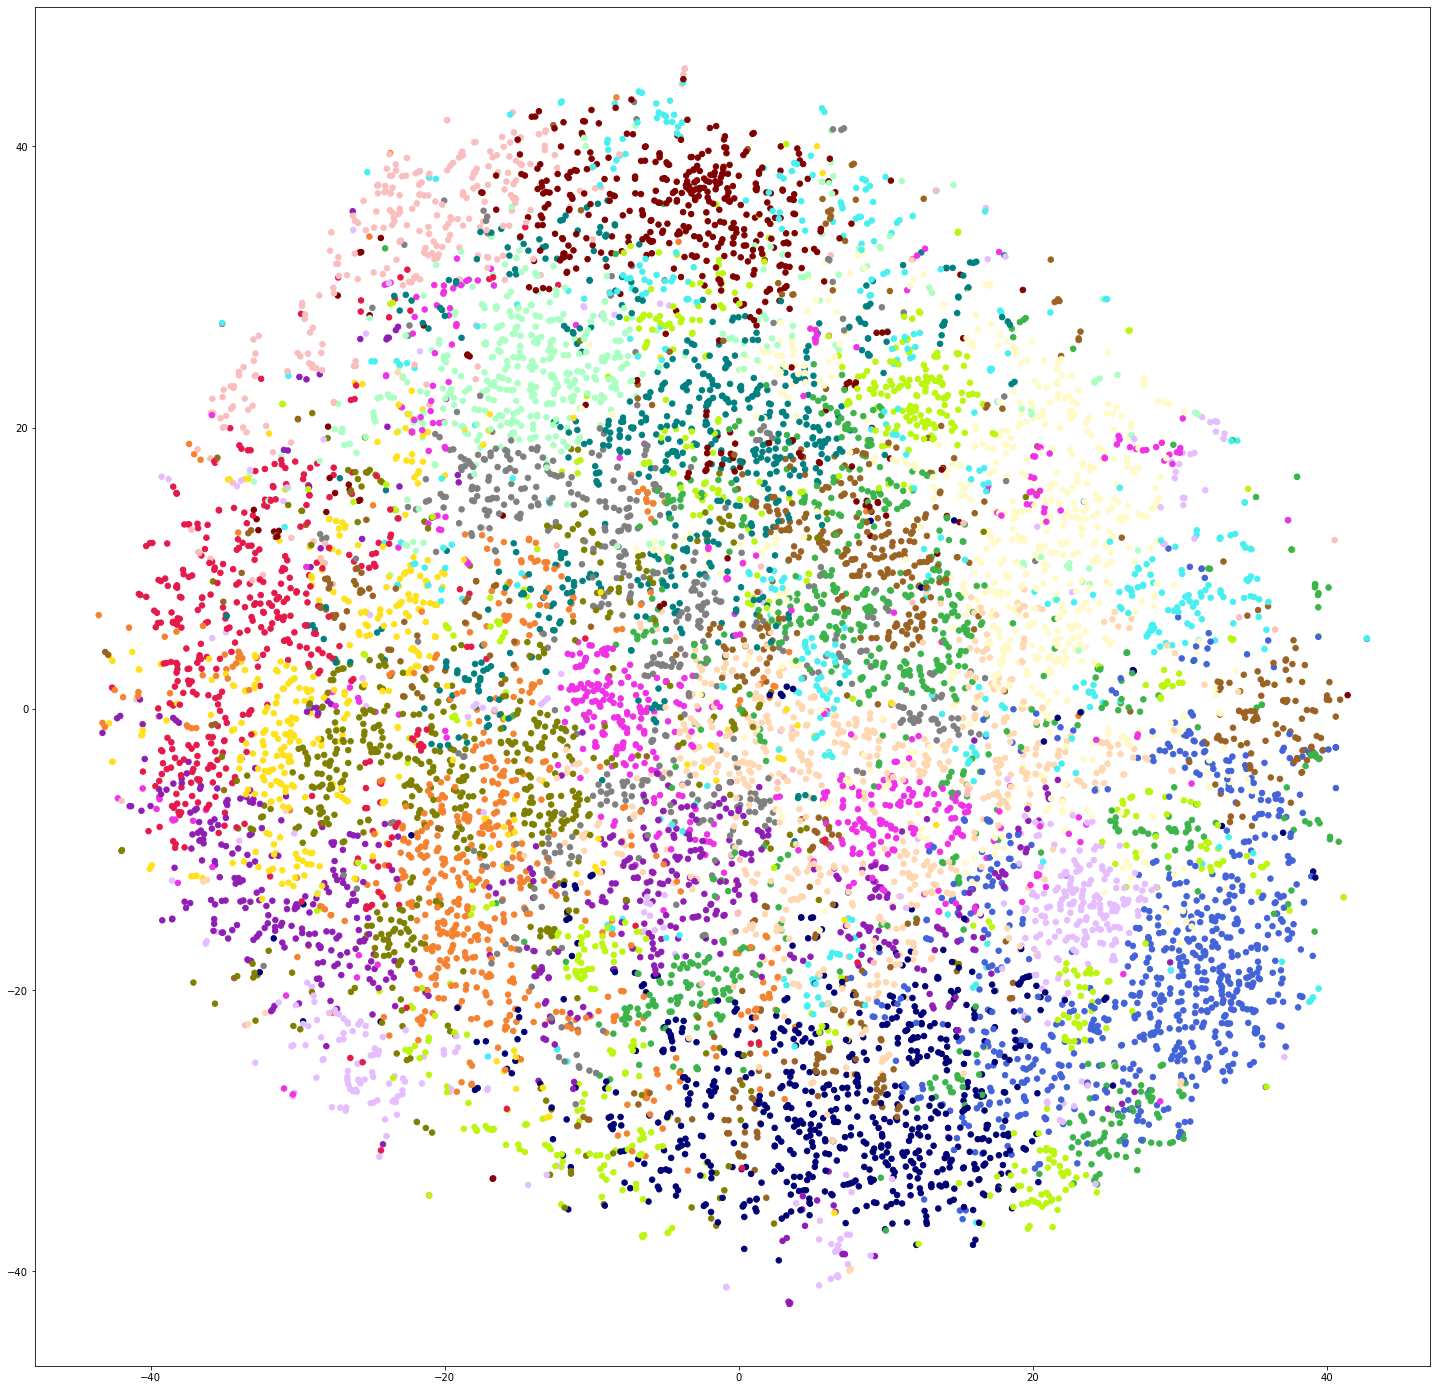

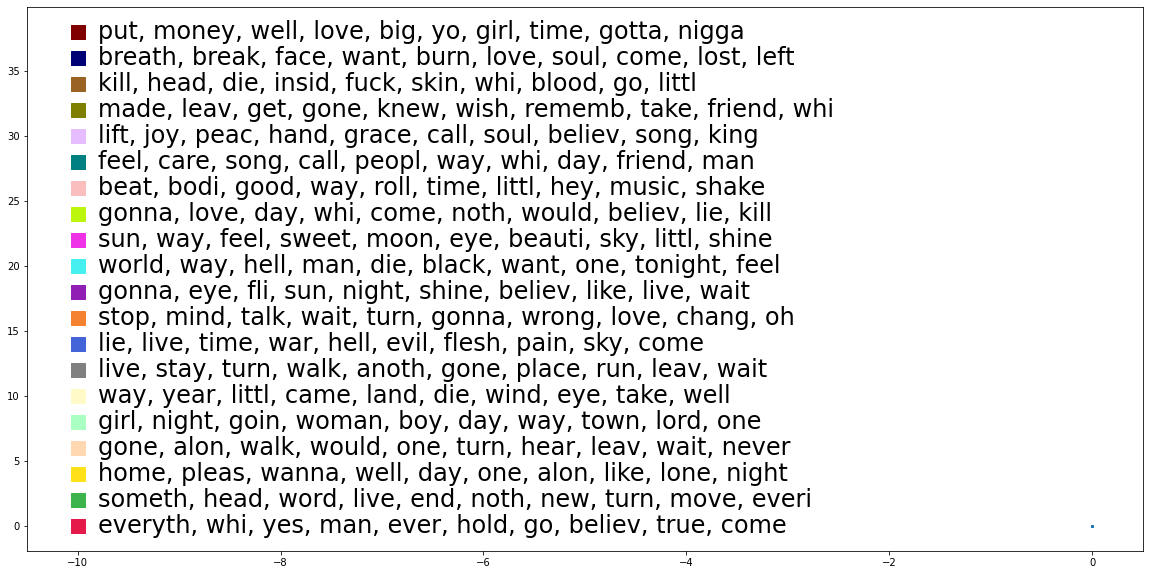

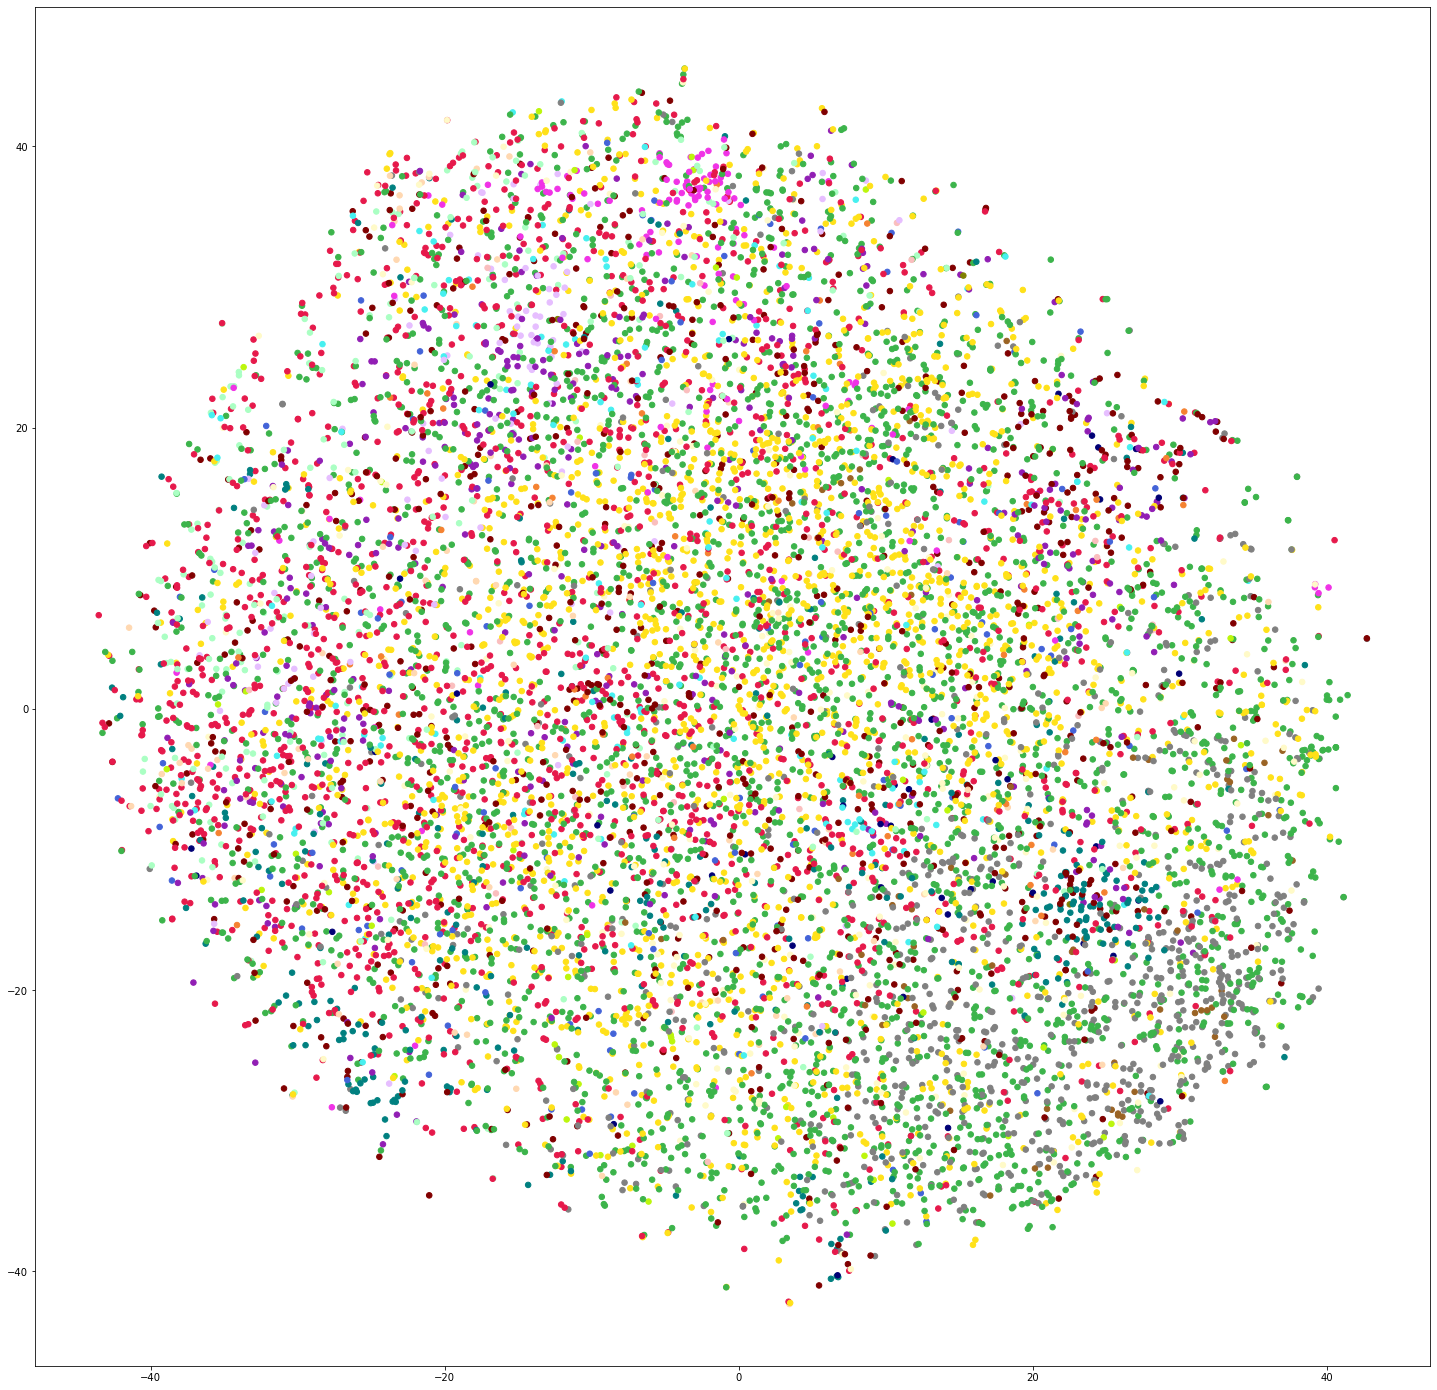

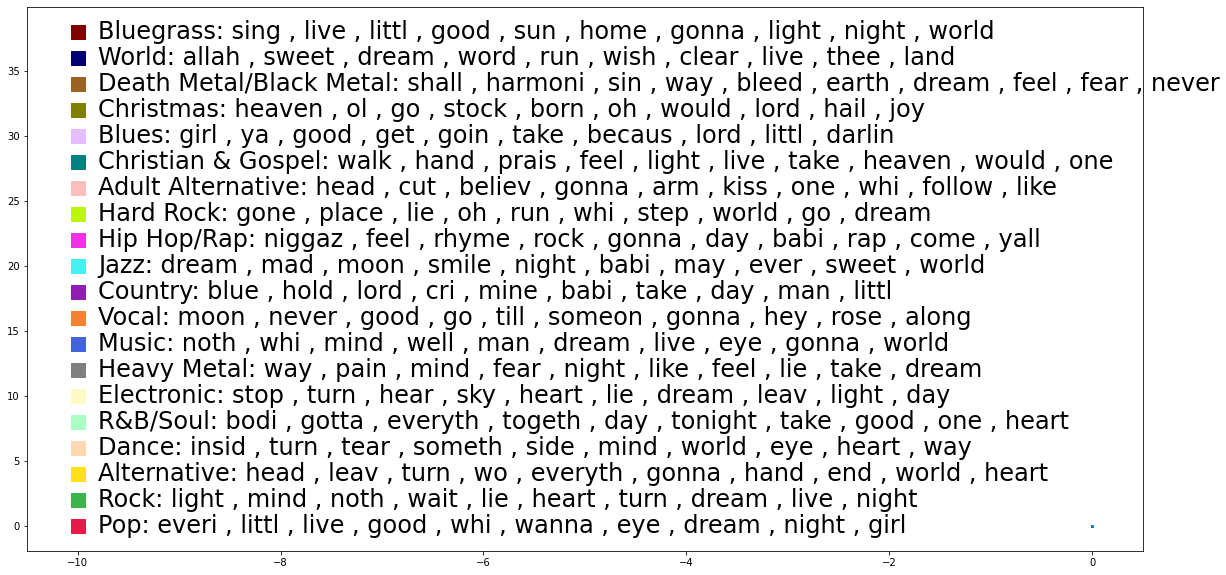

In [21]:
draw_scatter(tsne, clusters)
draw_legend(c_labels)
draw_scatter(tsne, [i['index'] for i in dict_test.values()])
#genre_l = [' , '.join(list(gen_tw[i].keys().to_numpy())[:-10]) for i in range(len(gen_tw))]
draw_legend(genres)

In [6]:
print(np.array([i.keys().to_numpy() for i in gen_tw]).flatten())

['everi' 'littl' 'live' 'good' 'whi' 'wanna' 'eye' 'dream' 'night' 'girl'
 'gonna' 'heart' 'take' 'way' 'day' 'babi' 'would' 'get' 'want' 'never'
 'like' 'one' 'feel' 'go' 'come' 'time' 'oh' 'love' 'know' 'cluster'
 'light' 'mind' 'noth' 'wait' 'lie' 'heart' 'turn' 'dream' 'live' 'night'
 'world' 'eye' 'get' 'want' 'day' 'take' 'oh' 'way' 'would' 'feel' 'go'
 'never' 'come' 'like' 'one' 'time' 'love' 'know' 'genre' 'cluster' 'head'
 'leav' 'turn' 'wo' 'everyth' 'gonna' 'hand' 'end' 'world' 'heart' 'noth'
 'eye' 'day' 'way' 'love' 'oh' 'feel' 'want' 'take' 'one' 'never' 'get'
 'come' 'would' 'go' 'time' 'like' 'know' 'genre' 'cluster' 'insid' 'turn'
 'tear' 'someth' 'side' 'mind' 'world' 'eye' 'heart' 'way' 'time' 'danc'
 'like' 'take' 'get' 'everybodi' 'go' 'night' 'dream' 'girl' 'one' 'oh'
 'feel' 'never' 'come' 'want' 'know' 'love' 'genre' 'cluster' 'bodi'
 'gotta' 'everyth' 'togeth' 'day' 'tonight' 'take' 'good' 'one' 'heart'
 'way' 'night' 'time' 'go' 'come' 'get' 'never' 'gonna' '

In [24]:
def compute_all_with_topwords(n_clust=20, length=1000, new_clustering=False):
    # load data
    # vectors from doc2vec model doc_id: [vector]
    inferred_vectors_dict = pickle.load( open( "inferred_vectors_dict.p", "rb" ) )
    # tf-idf matrix: doc_id w1 w2 ... wn
    df_countvect = pickle.load( open( "tfidf_df.p", "rb" ) )
    
    # np array of vectors
    X = np.array(list(inferred_vectors_dict.values()))[:length]
    
    # apply t-SNE
    X_embedded = TSNE(n_components=2, perplexity=200).fit_transform(X)
    X_embedded.shape  
    
    clustering = list(df_countvect['cluster'].to_numpy())[:length]
    if new_clustering:
        # cluster
        kmeans_model = KMeans(init='k-means++', n_clusters=n_clust, n_init=10)
        kmeans_model.fit(X)
        clustering  = kmeans_model.labels_

        # join clusters and tf-idf
        clust_df = pd.DataFrame({'cluster': clustering}, index=[i for i in inferred_vectors.keys()])
        df_countvect = df_countvect.join(clust_df)
    
    labels = []
    for i in range(n_clust):
        cluster = df_countvect.loc(0)[df_countvect.loc(1)['cluster'] == i]
        cluster_mean = cluster.mean()
        top_words = cluster_mean.sort_values()
        labels.append(top_words[-20:-10])
    return X_embedded, clustering, labels
        
#tsneData,clusters,labels = compute_all_with_topwords(n_clust=20, length=5000)        

In [128]:
sia_scores = pickle.load( open( "sia_scores.p", "rb" ) ) #test_documents
X = np.array([list(sia_scores[i].values()) for i in sia_scores.keys()])

In [122]:
def find_closest(document_id):
    np_scores = {k: v.values() for (k,v) in sia_scores.items()}
    sia_score_doc = np_scores[document_id]
    closest = [float('inf'), '']
    for (k,v) in np_scores.items():
        new_dist = np.linalg.norm(np.array(list(sia_score_doc))-np.array(list(v)))
        if new_dist != 0 and new_dist < closest[0]:
            closest = [new_dist, k]
    print(with_tfidf[closest[1]])
    print("\n")
    print(with_tfidf[document_id])
    return closest

In [121]:
def paint_test_genres():
    test_ids = [i[1][0] for i in test_documents_json]
    inf_vecs = pickle.load( open( "inferred_vectors_dict.p", "rb" ) ) #test_documents
    test_vecs = [(inf_vecs[vec],test_dict[vec]) for vec in test_ids]
    X = np.array([i[0] for i in test_vecs])

    genres = [i[1][1][1] for i in test_vecs]
    counter = collections.Counter(genres)
    for i in range(len(genres)):
        if counter[genres[i]] < 55:
            genres[i] = 0
    unique_colors = sorted(list(set(genres)),key= lambda x: counter[x])
    colors = [unique_colors.index(i) for i in genres]

    X_embedded = TSNE(n_components=2, perplexity=200).fit_transform(X)

    with open('genres.json','r') as file2:
        genre_names = json.load(file2) 
    genre_mapping = {i: [x['name'] for x in genre_names if x['genre_id'] == i] for i in unique_colors}

    plt.figure(figsize=(25, 25))

    plt.scatter([i[0] for i in X_embedded],[i[1] for i in X_embedded],c=colors,cmap='tab20', s=20)

    plt.scatter([-60 for i in list(set(colors))],[(i-10)*2 for i in list(set(colors))],c=list(set(colors)), cmap='tab20', s=20)
    for i in range(len(unique_colors)):
        txt = genre_mapping[unique_colors[i]]
        plt.annotate(txt, (-59, (i-10)*2))

In [121]:
def sentiment_analyzer(documents):
    sia = SentimentIntensityAnalyzer()
    polarity_scores = {}
    for doc in documents:
        polarity_scores[doc[1][0]] = sia.polarity_scores(' '.join(set(doc[0])))
    return polarity_scores
polarity_scores = sentiment_analyzer(docs)
with open("sia_scores","wb") as test_json:
    pickle.dump(polarity_scores,test_json)
test_json.close()